In [1]:
from scipy import signal
import numpy as np
from matplotlib import pyplot as plt 
import control
import tikzmagic
import warnings
warnings.filterwarnings('ignore')
from jupyterthemes import jtplot
jtplot.style()

%matplotlib inline

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

#### Initial modelling of the system

Euler-Lagrange Equations <br/>

\begin{align}
L & := T - V  \\ 
\end{align}
 
\begin{align}
\frac{d}{dt} \left(\frac{\partial L}{\partial \dot{q_i}} \right) - \frac{\partial L}{\partial q_i} = Q_i
\end{align}

For the pendulum we have $q$ as $x$ , this will give us the equations of movement for $x$. We also have $q$ as $\theta$, this will give us the equations of motion for $\theta$ , soon we'll need to solve both equations

\begin{align}
\frac{d}{dt} \left(\frac{\partial L}{\partial \dot{x}} \right) - \frac{\partial L}{\partial x} \\ \\
\frac{d}{dt} \left(\frac{\partial L}{\partial \dot{\theta}} \right) - \frac{\partial L}{\partial \theta}
\end{align}

Where T is the total kinetic energy of the system and V is the potential energy. Considering the cart as V = 0. For m,l,g,$\theta$ we have respectively the mass, length of the pendulum, gravity and the angle between the vertical and the pendulum 

\begin{align}
V & = mgl cos \theta \\
\end{align}

Now we are interested in calculating the kinetic energy of the system. Taking M as the total mass of the cart, F as the force that pushes the cart, we have

\begin{align}
T & = \frac{1}{2}\left(M+m\right)\dot{x}^2 - m\dot{x}l\dot{\theta}cos\theta + \frac{1}{2}ml^2\dot{\theta}^2   \\
\end{align}

Therefore

\begin{align}
L & = \frac{1}{2}\left(M+m\right)\dot{x}^2 - m\dot{x}l\dot{\theta}cos\theta + \frac{1}{2}ml^2\dot{\theta}^2 -mglcos\theta  \\
\end{align}

Solving both equations for $x$ and $\theta$ we have 

\begin{align}
(M+m)\ddot{x} + ml\dot{\theta}^2sen\theta - ml\ddot{\theta}cos\theta = F \\
\ddot{x}cos\theta + l\ddot{\theta} - gsen\theta = 0
\end{align}

This modelling is for a simple pendulum moved by a cartm for a physical pendulum, some adjustments are required. Every adjustment were taken from this thesis http://ethesis.nitrkl.ac.in/2213/1/Inverted_Pendulum.pdf

\begin{align}
(M+m)\ddot{x} + b\dot{x} - ml\dot{\theta}^2sen\theta + ml\ddot{\theta}cos\theta = F \\
ml\ddot{x}cos\theta + (I + ml^2)\ddot{\theta} - mglsen\theta = 0
\end{align}

##### Linearization about a point

\begin{align}
\theta = \Pi + \phi \\ 
\\
\end{align}
Being $\phi \approx 0$ we can make a small angle approximation
\begin{align}
\\
cos\phi = -1 \\
sen\phi = \phi \\
\dot{\theta} = 0 \\
\\
\end{align}
After the linearization we have
\begin{align}
(M+m)\ddot{x} + b\dot{x} -ml\dot{\phi} = u \\
(I + ml^2)\ddot{\phi} -mgl\phi - ml\ddot{x} = 0
\\
\end{align}
#### Laplace
\begin{align}
X(s)(M+m)s^2 + X(s)bs -\Phi(s)mls = U(s) \\
\Phi(s)(I + ml^2)s^2 -\Phi(s)mgls - X(s)mls^2 = 0
\\
\end{align}

#### Transfer functions

\begin{align}
\frac{X(s)}{U(s)} = \frac{(I + ml^2)s^2 - mgl}{ [(M+m)(I + ml^2) - ml^2]s^4 + b(I + mIl^2)s^3 - (M + m)mgls^2 -mglbs} \\
\\
\end{align}
\begin{align}
\frac{\Phi(s)}{U(s)} = \frac{\frac{ml}{q}s}{s^3 - \frac{b(I+ml^2)}{q}s^2 - \frac{(M+m)mgl}{q}s - \frac{bmgl}{q}}
\\
q := [(M+m)(I+ml^2) - ml^2]
\end{align}

Igoring the friction ( Oh my dear hearth ) and applying the parameters we have

\begin{align}
\frac{X(s)}{U(s)} = \frac{b_2}{s^2} \\
\\
\end{align}
\begin{align}
\frac{\Phi(s)}{U(s)} = \frac{b_1}{s^2 - a_1^2}
\end{align}

Where 

\begin{align}
\therefore && b_1 = 0.2570 &&
a_1 = 6.6307 && 
b_2 = 0.3802 & \implies
\frac{X(s)}{U(s)} = \frac{0.3802}{s^2} && \frac{\Phi(s)}{U(s)} = \frac{0.2570}{s^2 - 6.6307}
\end{align}

#### Inverted pendulum Time Domain

Just the angle transfer function
\begin{align}
\\
\frac{\Phi(s)}{U(s)} = \frac{0.2570}{s^2 - 6.6307}
\end{align}

In [5]:
num = [0.2570]
den = [1,0,-6.6370]
ft_angulo = signal.TransferFunction(num, den)

In [6]:
polos = ft_angulo.poles
polos

array([ 2.57623757, -2.57623757])

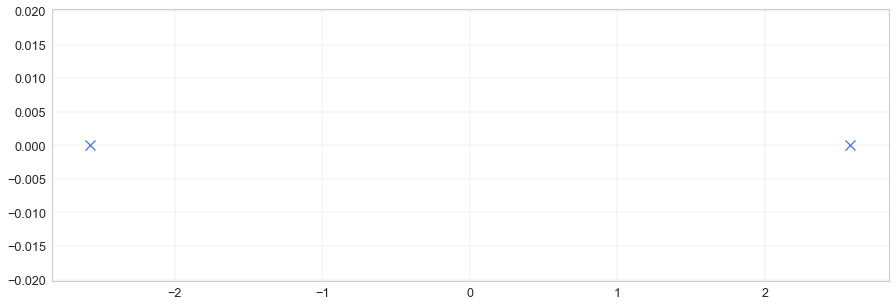

In [7]:
fig = plt.figure(figsize=(15,5))
plt.grid(True,linewidth=.3)
[plt.scatter(polo,0,marker='x',c='b',s=100) for polo in polos]
plt.show()


### Step and Impulse Response

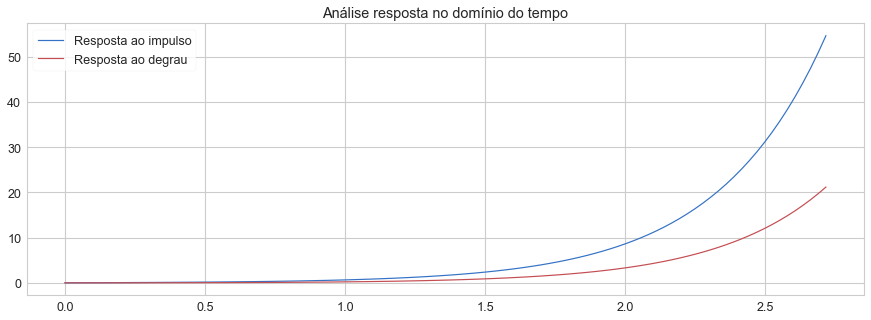

In [8]:
fig = plt.figure(figsize=(15,5))
t,y = signal.impulse(ft_angulo)
t_degrau,y_degrau = signal.step(ft_angulo)
plt.plot(t,y)
plt.plot(t_degrau,y_degrau,'r')
plt.legend(['Resposta ao impulso','Resposta ao degrau'])
plt.title('Análise resposta no domínio do tempo')
plt.show()

### Control

In [9]:
roots_real = []
roots_img = []
colors_vec = []
ks = np.linspace(0,50,30)
for k in ks:
    tf = [1,0,0.2570*k - 6.6370]
    poles = np.roots(tf)
    [roots_real.append(pole.real) for pole in poles]
    [roots_img.append(pole.imag) for pole in poles]
    colors_vec.append(0)
    colors_vec.append(1)
           
def update_rootlocus(kp):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 1, 1)
    colors = ['b','r']
    ax.grid(True)
    ax.set_ylim(-3,3)
    ax.set_xlim(-3,3)
    plt.scatter(2.57,0,s=150,c=colors[0],marker='X')
    plt.scatter(-2.57,0,s=150,c=colors[1],marker='X')
    for i in range(len(roots_real)):
        plt.scatter(roots_real[i],roots_img[i],marker='x',s=100,c=colors[colors_vec[i]])
        
    tf_interact = [1,0,0.2570*kp - 6.6370]
    poles_interact = np.roots(tf_interact)
    is_real_interact = np.isreal(poles_interact[0])
    if is_real_interact:
        for i,pole in enumerate(poles_interact):
            plt.scatter(pole,0,s=150,marker='o',c=colors[i])
    else:
        for i,pole in enumerate(poles_interact):
            plt.scatter(pole.real,pole.imag,s=150,marker='o',c=colors[i])
    legend_1 = str(round(poles_interact[0].real,3)) + ' + ' + str(round(poles_interact[0].imag,3))  + 'j'
    legend_2 = str(round(poles_interact[1].real,3)) + ' + ' + str(round(poles_interact[1].imag,3))  + 'j'
    ax.legend([legend_1,legend_2])

    plt.show()
    
interact(update_rootlocus,kp=(-5,50,1))

interactive(children=(IntSlider(value=22, description='kp', max=50, min=-5), Output()), _dom_classes=('widget-…

<function __main__.update_rootlocus(kp)>

### PID Control

In [10]:
from control import tf,feedback,step_response,impulse_response
def pzmap(transfer_function):
    # plot the poles and zeros of the transfer function
    poles = transfer_function.pole()
    zeros = transfer_function.zero() 
    plt.xlim(20,-20)
    plt.ylim(20,-20)
    [plt.scatter(pole.real,pole.imag,marker='X') for pole in poles]
    [plt.scatter(zero.real,zero.imag,marker='o') for zero in zeros]
    plt.grid()
    plt.show()
    
def _step(transfer_function):
    # plot the step response for the transfer function
    T, yout = step_response(transfer_function)
    plt.plot(T,yout)
    plt.show()

In [11]:
# PID ISA Kc (1 + 1/(Ti * s) + Td * s )

colors = ['rosybrown','olivedrab','darkgoldenrod','lightslategray']

def test_PID(K,Ti,Td,points,step_function,show_zeros_and_poles,ax_autoresize):
    roots_real = []
    roots_img = []
    color_vector = []
    Kcs = np.linspace(0,250,points)
    s = tf([1,0],1)
    G = (0.2570)/(s**2 - 6.6370)
    for Kc in Kcs:
        if(Ti == 0):
            Gc = Kc*(1 + s*Td)
        else:
            Gc = Kc*(1 + s*Td + 1/(Ti*s))
        closed_loop_tf = feedback(Gc*G,1)
        poles = closed_loop_tf.pole()
        how_many_poles = len(poles)
        counter = 0
        if(how_many_poles > 0):
            for i,pole in enumerate(poles):
                roots_real.append(poles[i].real)
                roots_img.append(poles[i].imag)
                color_vector.append(colors[counter])
                counter += 1
                if(counter == how_many_poles): counter = 0
    length = 5
    if(step_function): length = 10
    fig = plt.figure(figsize=(15,length))
    if(step_function):
        ax = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)
        ax2.grid(True)
    else:
        ax = fig.add_subplot(111)
    ax.grid(True)
    
    for i in range(len(roots_real)):
        ax.scatter(roots_real[i],roots_img[i],marker='x',s=30,color=color_vector[i])
    
    if(K != 0):
        if(Ti == 0):
            Gc = K*(1 + s*Td)
        else:
            Gc = K*(1 + s*Td + 1/(Ti*s))
        closed_loop_tf = feedback(Gc*G,1)
        _poles = closed_loop_tf.pole()
        _zeros = closed_loop_tf.zero()
        [ax.scatter(pole.real,pole.imag,marker='X',s=100,color='black') for pole in _poles]
        [ax.scatter(zero.real,zero.imag,marker='o',s=100,color='darkgreen') for zero in _zeros]
        if(step_function):
            T, yout = step_response(closed_loop_tf)
            ax2.plot(T,yout)
        total_number_of_poles_and_zeros = len(_poles) + len(_zeros)
        legends = []
        [legends.append(str(round(pole.real,3)) + ' + ' + str(round(pole.imag,3))  + 'j') for pole in _poles]
        [legends.append(str(round(zero.real,3)) + ' + ' + str(round(zero.imag,3))  + 'j') for zero in _zeros]
        if(show_zeros_and_poles): ax.legend(legends)
        if(not ax_autoresize):
            ax.set_ylim(-5,5)
            ax.set_xlim(-5,5)
      
        
interact(test_PID,
         K=widgets.BoundedFloatText(
                            value=0,
                            min=-500,
                            max=500.0,
                            step=.2,
                            description='K:',
                            disabled=False
                        ),
         Ti=widgets.BoundedFloatText(
                            value=0,
                            min=-500,
                            max=500.0,
                            step=.01,
                            description='Ti:',
                            disabled=False
                        ),
         Td=widgets.BoundedFloatText(
                            value=0,
                            min=-500,
                            max=500.0,
                            step=.01,
                            description='Td:',
                            disabled=False
                        ),
         points=widgets.BoundedFloatText(
                            value=10,
                            min=10.0,
                            max=200.0,
                            step=1,
                            description='Points:',
                            disabled=False
                        ),
         step_function = widgets.Checkbox(
                                            value=False,
                                            description='Resposta ao Degrau',
                                            disabled=False
                                        ),
         show_zeros_and_poles = widgets.Checkbox(
                                            value=True,
                                            description='Mostrar polos e zeros',
                                            disabled=False
                                        ),
         ax_autoresize = widgets.Checkbox(
                                            value=True,
                                            description='Auto ajustar escala',
                                            disabled=False
                                        )
        )
#K=widgets.FloatSlider(min=-1000.0, max=1000.0, value=1,step=0.2, description='K')

interactive(children=(BoundedFloatText(value=0.0, description='K:', max=500.0, min=-500.0, step=0.2), BoundedF…

<function __main__.test_PID(K, Ti, Td, points, step_function, show_zeros_and_poles, ax_autoresize)>

### Even more functionality

In [12]:
""" General parameters """
tab_titles   = ['Simulation','Process Transfer Function','ISA PID Parameters']

""" Tab Plant """
label_numerador = widgets.Label('Numerator :',layout = widgets.Layout(width = '12%'))
box_layout = widgets.Text(layout=widgets.Layout(width = "15%",height = '40px'))
numerador = widgets.Text(layout = box_layout.layout)
space = widgets.Label('',layout = widgets.Layout(width = '3%')) 
tip = widgets.Label('e.g 1,0,-6.6370 --> s^2 - 6.6370',layout = widgets.Layout(width = '25%'))

container_numerador = widgets.HBox(children=[label_numerador,numerador,space,tip])

label_denominador = widgets.Label('Denominator :',layout = widgets.Layout(width = '12%'))
denominador = widgets.Text(layout = box_layout.layout)
container_denominador = widgets.HBox(children=[label_denominador,denominador])

container_plant = widgets.VBox(children=[container_numerador,container_denominador])

""" Tab ISA PID Parameters """

def k_box(description,tip,default_value):
    label_kp = widgets.Label(description + ' :',layout = widgets.Layout(width = '4%'))
    box_layout = widgets.Text(layout=widgets.Layout(width = "15%",height = '40px'))
    kp = widgets.BoundedFloatText(
                                value=default_value,
                                min=-1000.0,
                                max=1000.0,
                                step=.05,
                                disabled=False,
                                layout = box_layout.layout
                            )
    space = widgets.Label('',layout = widgets.Layout(width = '3%')) 
    tip_kp = widgets.Label(tip,layout = widgets.Layout(width = '20%'))

    return widgets.HBox(children=[label_kp,kp,space,tip_kp])

container_kp = k_box('Kp','Proportional part',1)
container_Td = k_box('Td','Derivative part',0)
container_Ti = k_box('Ti','Integral part',0)

container_ISA_PID = widgets.VBox(children=[container_kp,container_Td,container_Ti])

""" Config parameters """
def config_box(description,tip,Min,Max,default_value,step):
    label_kp = widgets.Label(description + ' :',layout = widgets.Layout(width = '10%'))
    box_layout = widgets.Text(layout=widgets.Layout(width = "15%",height = '40px'))
    kp = widgets.BoundedFloatText(
                                value=default_value,
                                min=Min,
                                max=Max,
                                step=step,
                                disabled=False,
                                layout = box_layout.layout
                            )
    space = widgets.Label('',layout = widgets.Layout(width = '3%')) 
    tip_kp = widgets.Label(tip,layout = widgets.Layout(width = '25%'))

    return widgets.HBox(children=[label_kp,kp,space,tip_kp])

container_kpoints = config_box("K point's",'Root locus range of points for k',10,1000,10,1)
container_linspace = config_box("Spacement",'Parameter for linspace of the K points',1,1000,10,1)
container_config = widgets.VBox(children=[container_kpoints,container_linspace])

""" Contents of the GUI """
tab_contents = [container_config,container_plant,container_ISA_PID]

""" Creating the tab element """
tab = widgets.Tab()
tab.children = tab_contents

""" Indexing titles for the tabs """
[tab.set_title(i,tab_titles[i]) for i in range(len(tab_titles))]

""" Displaying """
display(tab)

""" Update function for the animation """
def ISA_PID(GUI_container):
    fig = plt.figure(figsize=(15,10))
    #plt.close()
    ax = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax2.grid(True)
    ax.grid(True)
    """ Simulation """
    k_range = tab.children[0].children[0].children[1].value
    spacement = tab.children[0].children[1].children[1].value
    # for test purposes 
    tab.children[0].children[0].children[1].value = 500
    """ Plant """
    numerador_value = tab.children[1].children[0].children[1].value
    denominador_value = tab.children[1].children[1].children[1].value
    # for test purposes
    tab.children[1].children[0].children[1].value = '0.2570'
    tab.children[1].children[1].children[1].value = '1,0,-6.6370'
    """ ISA PID Parameters """
    K = tab.children[2].children[0].children[1].value
    Td = tab.children[2].children[1].children[1].value
    Ti = tab.children[2].children[2].children[1].value

    if(numerador_value != ''): 
        num = np.array([np.float(numero) for numero in numerador_value.split(',')])
    else:
        num = 1 
    if(denominador_value != ''):
        den = np.array([np.float(numero) for numero in denominador_value.split(',')])
    else:
        den = 1
    G = tf(num,den)
    print('Transfer Function : ', G)
    """ Simulation part """
    roots_real = []
    roots_img = []
    color_vector = []
    Kcs = np.linspace(0,k_range,spacement)
    s = tf([1,0],1)
    if( (type(np.ones(1)) == type(num)) or (type(np.ones(1)) == type(den)) ):
        for Kc in Kcs:
            if(Ti == 0):
                Gc = Kc*(1 + s*Td)
            else:
                Gc = Kc*(1 + s*Td + 1/(Ti*s))
            closed_loop_tf = feedback(Gc*G,1)
            poles = closed_loop_tf.pole()
            how_many_poles = len(poles)
            counter = 0
            if(how_many_poles > 0):
                for i,pole in enumerate(poles):
                    roots_real.append(poles[i].real)
                    roots_img.append(poles[i].imag)
                    color_vector.append(colors[counter])
                    counter += 1
                    if(counter == how_many_poles): counter = 0
        length = 5
        for i in range(len(roots_real)):
            ax.scatter(roots_real[i],roots_img[i],marker='x',s=30,color=color_vector[i])

        if(K != 0):
            if(Ti == 0):
                Gc = K*(1 + s*Td)
            else:
                Gc = K*(1 + s*Td + 1/(Ti*s))
            closed_loop_tf = feedback(Gc*G,1)
            _poles = closed_loop_tf.pole()
            _zeros = closed_loop_tf.zero()

            [ax.scatter(pole.real,pole.imag,marker='X',s=100,color='black') for pole in _poles]
            [ax.scatter(zero.real,zero.imag,marker='o',s=100,color='darkgreen') for zero in _zeros]
            T, yout = step_response(closed_loop_tf)
            ax2.plot(T,yout)
            total_number_of_poles_and_zeros = len(_poles) + len(_zeros)
            legends = []
            [legends.append(str(round(pole.real,3)) + ' + ' + str(round(pole.imag,3))  + 'j') for pole in _poles]
            [legends.append(str(round(zero.real,3)) + ' + ' + str(round(zero.imag,3))  + 'j') for zero in _zeros]
            ax.legend(legends)
        
interact(ISA_PID,GUI_container=widgets.ToggleButton(
            description='Simulate!',
            button_style='info', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Atualizar parêmetros',
            icon='check'
        )
)

interactive(children=(ToggleButton(value=False, button_style='info', description='Simulate!', icon='check', to…

<function __main__.ISA_PID(GUI_container)>